# IMDb Top 1000 Movies Analysis: Clustering & Classification Techniques

This notebook demonstrates the use of unsupervised clustering and supervised classification on the cleaned IMDb Top 1000 Movies dataset. We'll apply K-Means clustering to uncover natural groupings and build a Logistic Regression model to predict whether a movie is highly rated. The narrative is interwoven with code cells and visualizations to guide you through the analysis.

## 1. Introduction

In this analysis we will:
- **Clustering:**  
  - Use numerical features such as Gross, Runtime and Meta_score.  
  - Determine the optimal number of clusters using the Elbow Method and Silhouette Score.  
  - Visualize clusters in 2D using dimensionality reduction.

- **Classification:**  
  - Create a binary target variable (e.g., `Is_Highly_Rated` where IMDb_Rating ≥ 8.0 is considered high).  
  - Build and evaluate a Logistic Regression classifier.
  
Let's begin by loading the cleaned dataset.


In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load the cleaned dataset
movies = pd.read_csv('imdb_top_1000_cleaned.csv')
print("Dataset shape:", movies.shape)
movies.head()


Dataset shape: (1000, 23)


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,Star4,No_of_Votes,Gross,Duration,No_of_Votes_clean,Decade,Gross_clean,actors,combined_features,Is_Highly_Rated
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,...,William Sadler,2343110,28341469.0,142.0,2343110.0,1990.0,28341469.0,Tim Robbins Morgan Freeman Bob Gunton William ...,Drama Frank Darabont Tim Robbins Morgan Freema...,1
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,...,Diane Keaton,1620367,134966411.0,175.0,1620367.0,1970.0,134966411.0,Marlon Brando Al Pacino James Caan Diane Keaton,"Crime, Drama Francis Ford Coppola Marlon Brand...",1
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,...,Michael Caine,2303232,534858444.0,152.0,2303232.0,2000.0,534858444.0,Christian Bale Heath Ledger Aaron Eckhart Mich...,"Action, Crime, Drama Christopher Nolan Christi...",1
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,...,Diane Keaton,1129952,57300000.0,202.0,1129952.0,1970.0,57300000.0,Al Pacino Robert De Niro Robert Duvall Diane K...,"Crime, Drama Francis Ford Coppola Al Pacino Ro...",1
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,...,John Fiedler,689845,4360000.0,96.0,689845.0,1950.0,4360000.0,Henry Fonda Lee J. Cobb Martin Balsam John Fie...,"Crime, Drama Sidney Lumet Henry Fonda Lee J. C...",1


## 2. Data Overview and Feature Selection

The dataset contains 1000 rows and includes columns such as:
- **Poster_Link, Series_Title, Released_Year, Certificate, Runtime, Genre, IMDB_Rating, Overview, Meta_score, Director, Star1-4, No_of_Votes, Gross, Duration, etc.**

For this analysis, we'll focus on the following numerical features for clustering:
- `Gross_clean` (or Gross)
- `Runtime` 
- `IMDB_Rating`
- `Meta_score`

We'll also create a binary target variable `Is_Highly_Rated` where movies with an IMDB_Rating of 8.0 or higher are marked as 1.


In [31]:
# Create binary target variable: 1 if IMDB_Rating >= 8.0, else 0
movies['Is_Highly_Rated'] = np.where(movies['IMDB_Rating'] >= 8.0, 1, 0)

# Select relevant numerical features for clustering
features = ['Gross_clean', 'Runtime', 'Meta_score']

# Convert 'Runtime' if needed. Here, assuming it's already in numeric minutes.
movies_features = movies[features]
movies_features = movies[features].fillna(movies[features].median())


# Normalize features
scaler = StandardScaler()
movies_scaled = scaler.fit_transform(movies_features)

# Display the prepared feature set
pd.DataFrame(movies_scaled, columns=features).head()


,Gross_clean,Runtime,Meta_score
0,-0.317378,0.680529,0.164312
1,0.734477,1.855759,1.924482
2,4.679413,1.036659,0.516346
3,-0.031702,2.817310,1.044397
4,-0.553955,-0.957670,1.572448


## 3. Clustering with K-Means

### 3.1 Finding the Optimal Number of Clusters

We'll use the Elbow Method and Silhouette Score to identify the optimal number of clusters for K-Means.


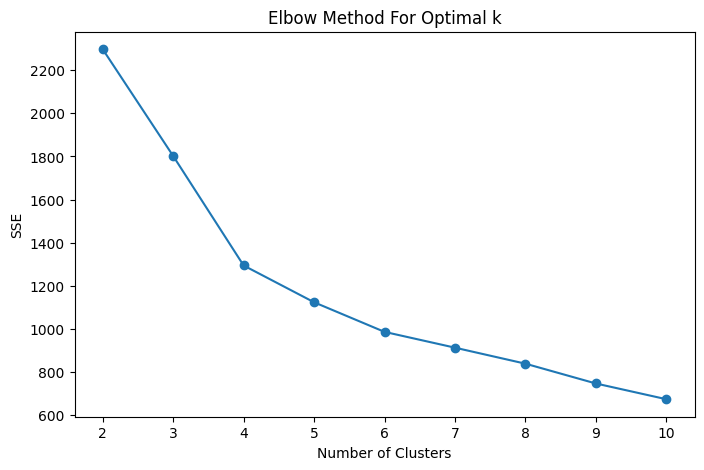

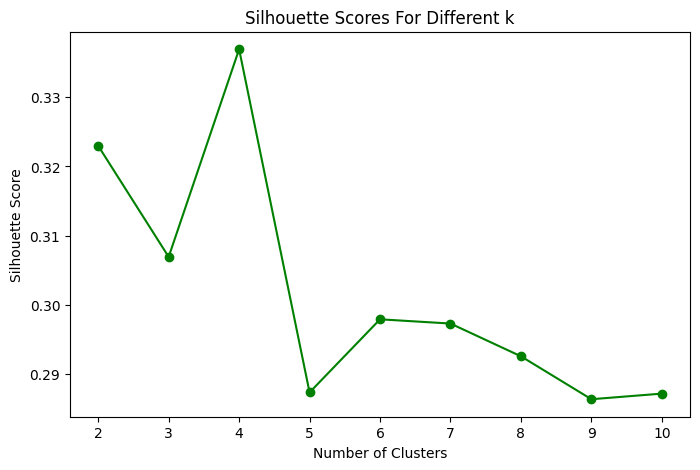

In [32]:
# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(movies_scaled)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Calculate silhouette scores for different k values
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(movies_scaled)
    score = silhouette_score(movies_scaled, labels)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Scores For Different k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


### 3.2 Applying K-Means and Visualizing Clusters

After evaluating the plots, suppose we decide on 4 clusters. We'll apply K-Means clustering and use PCA to project the clusters onto a 2D plane for visualization.


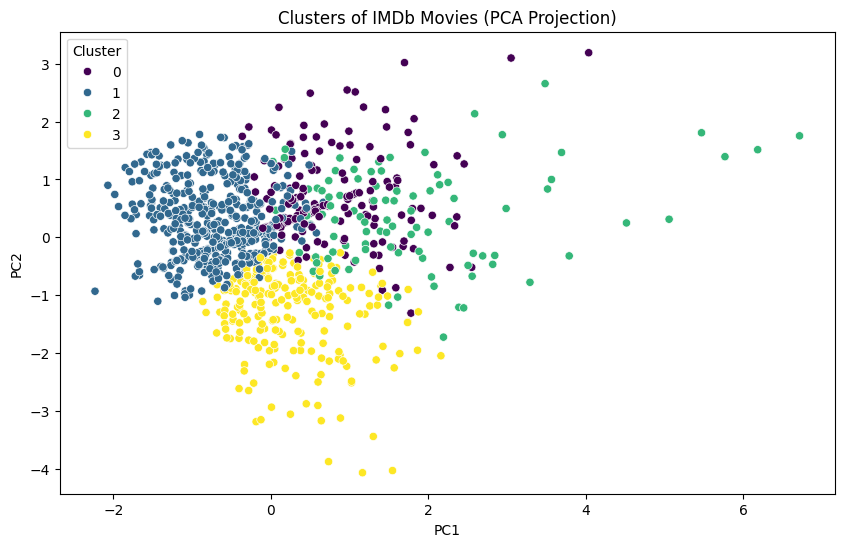

Movies in Cluster 0:
                       Series_Title  Gross_clean  Runtime  Meta_score
0          The Shawshank Redemption   28341469.0      142        80.0
1                     The Godfather  134966411.0      175       100.0
3            The Godfather: Part II   57300000.0      202        90.0
6                      Pulp Fiction  107928762.0      154        94.0
7                  Schindler's List   96898818.0      195        94.0
12  Il buono, il brutto, il cattivo    6100000.0      161        90.0
15                       Goodfellas   46836394.0      146        90.0
18                         Hamilton          NaN      160        90.0
20                  Soorarai Pottru          NaN      153        79.0
21                     Interstellar  188020017.0      169        74.0
Movies in Cluster 1:
                       Series_Title  Gross_clean  Runtime  Meta_score
4                      12 Angry Men    4360000.0       96        96.0
17  One Flew Over the Cuckoo's Nest  112000000.0

In [40]:
# Apply K-Means with the chosen number of clusters (e.g., k = 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['Cluster'] = kmeans.fit_predict(movies_scaled)

# Use PCA for 2D visualization of clusters
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(movies_scaled)
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = movies['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title("Clusters of IMDb Movies (PCA Projection)")
plt.show()

# Movies that belong to cluster 0
cluster_0_movies = movies[movies['Cluster'] == 0]
print("Movies in Cluster 0:")
print(cluster_0_movies[['Series_Title',  'Gross_clean', 'Runtime', 'Meta_score']].head(10))

# Movies that belong to cluster 1
cluster_1_movies = movies[movies['Cluster'] == 1]
print("Movies in Cluster 1:")
print(cluster_1_movies[['Series_Title', 'Gross_clean', 'Runtime', 'Meta_score']].head(10))

# Movies that belong to cluster 2
cluster_2_movies = movies[movies['Cluster'] == 2]
print("Movies in Cluster 2:")
print(cluster_2_movies[['Series_Title', 'Gross_clean', 'Runtime', 'Meta_score']].head(10))

# Movies that belong to cluster 3
cluster_3_movies = movies[movies['Cluster'] == 3]
print("Movies in Cluster 3:")
print(cluster_3_movies[['Series_Title', 'Gross_clean', 'Runtime', 'Meta_score']].head(10))

## 4. Classification with Logistic Regression

### 4.1 Data Preparation

For classification, we'll use the same set of features and the binary target variable `Is_Highly_Rated`. We'll split the data into training and testing sets.


In [34]:
# Prepare data for classification

# features.remove('IMDB_Rating')
movies_features = movies[features].fillna(movies[features].median())
X = movies_features
y = movies['Is_Highly_Rated']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features for training and testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 4.2 Training and Evaluating the Logistic Regression Model

We train a logistic regression classifier and then evaluate its performance using accuracy, precision, recall, F1-score, and a confusion matrix.


Accuracy: 0.635
Precision: 0.6285714285714286
Recall: 0.4835164835164835
F1-Score: 0.546583850931677


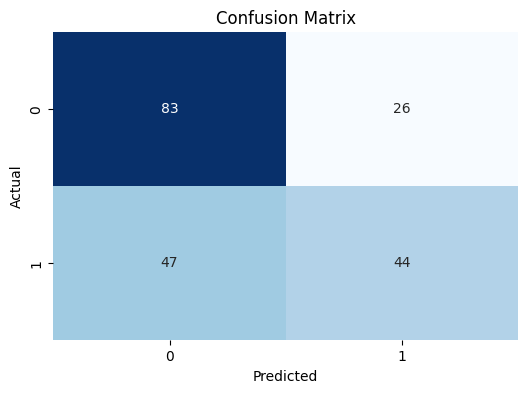

In [35]:
# Normalize the features for training and testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 4.3 Interpreting the Model

We inspect the logistic regression coefficients to understand which features most affect the likelihood of a movie being highly rated.


In [36]:
# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': logreg.coef_[0]
})
print(coefficients)


       Feature  Coefficient
0  Gross_clean     0.008743
1      Runtime     0.484407
2   Meta_score     0.422534


## 5. Reflection and Insights

### Clustering vs. Classification

- **Clustering Insights:**  
  The clusters reveal natural groupings based on financial metrics, runtime, and ratings. These groups can provide insights into different types of movies (e.g., blockbuster hits vs. niche films).

- **Classification Insights:**  
  The logistic regression model helps identify the features that most strongly influence a movie being highly rated. This insight could guide further feature engineering or model improvements.

### Future Directions

- Explore additional clustering techniques (e.g., hierarchical clustering or DBSCAN).  
- Experiment with more complex classification models, such as Random Forest or SVM, to potentially improve performance.

---

## 6. Conclusion

In this notebook, we demonstrated a structured approach to:
- Apply K-Means clustering on the cleaned IMDb Top 1000 Movies dataset.
- Build and evaluate a Logistic Regression classifier.
- Integrate narrative, visualizations, and code to provide a comprehensive data story.

This framework sets the stage for further exploratory analysis and model refinement.


## Bonus Challenge: Alternative Clustering with DBSCAN

In addition to K-Means, we can explore clustering using DBSCAN. DBSCAN is a density-based clustering method that does not require specifying the number of clusters in advance. It can identify clusters of varying shapes and also mark out noise points (labeled as -1).

We'll apply DBSCAN on our normalized features and visualize the resulting clusters using PCA.


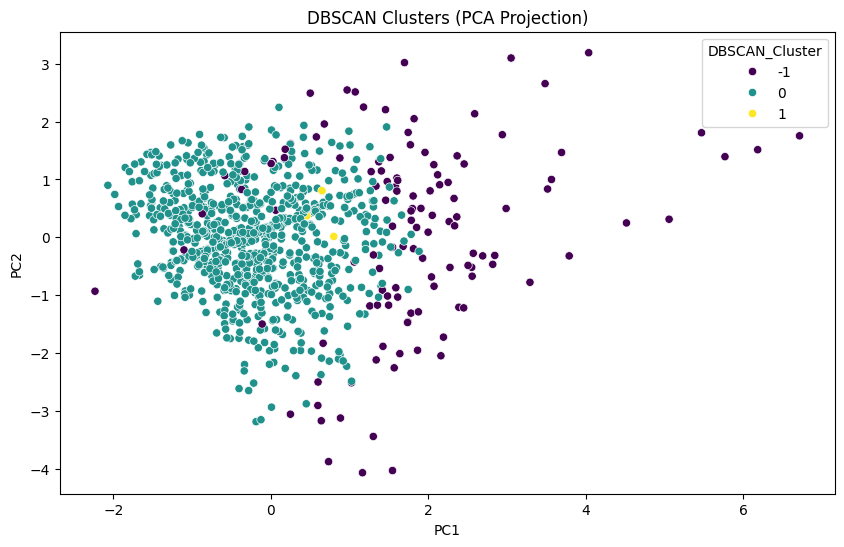

In [37]:
from sklearn.cluster import DBSCAN

# Configure DBSCAN parameters; eps and min_samples may require tuning.
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(movies_scaled)

# Add the DBSCAN cluster labels to the DataFrame
movies['DBSCAN_Cluster'] = dbscan_labels

# Use our existing PCA components (from previous cells) for visualization
pca_dbscan_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_dbscan_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_dbscan_df, palette='viridis', legend='full')
plt.title("DBSCAN Clusters (PCA Projection)")
plt.show()


## Bonus Challenge: Classification with a More Complex Classifier

For the classification task, we previously used Logistic Regression. Now, we’ll try a more complex classifier, the Random Forest, to see if it improves performance. Random Forests are ensemble models that can capture non-linear relationships and interactions among features.

We'll train the Random Forest classifier using the same features and data splits, then compare its performance (using metrics such as accuracy, precision, recall, and F1-score) to our earlier logistic regression results.


Random Forest Classifier Performance:
Accuracy: 0.62
Precision: 0.5862068965517241
Recall: 0.5604395604395604
F1-Score: 0.5730337078651685

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66       109
           1       0.59      0.56      0.57        91

    accuracy                           0.62       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.62      0.62      0.62       200



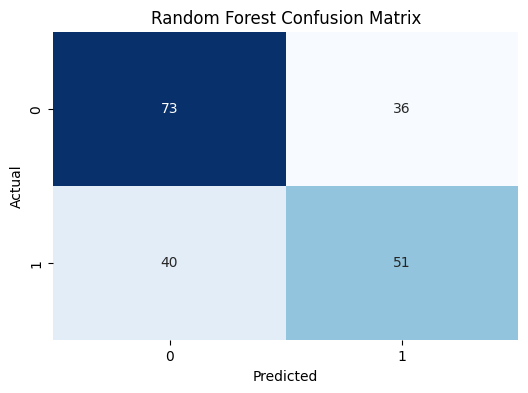

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Prepare data for classification

X = movies[features].fillna(movies[features].median())
y = movies['Is_Highly_Rated']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features for training and testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and train the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluate the classifier's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-Score:", f1_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()